In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_spam = pd.read_csv(r'spam.csv')
df_spam['spam']=df_spam['Category'].apply(lambda x: 1 if x=='spam' else 0)

df_spam.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_spam['Message'],df_spam['spam'], stratify=df_spam['spam'])

# Build Model

In [4]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2021-11-07 20:03:43.287284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-07 20:03:43.295567: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-07 20:03:44.622489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
# def get_sentence_embeding(sentences):
#     preprocessed_text = bert_preprocess(sentences)
#     return bert_encoder(preprocessed_text)['pooled_output']

In [6]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
hidden1 = tf.keras.layers.Dense(64, activation='sigmoid')(outputs['pooled_output'])
dropout1 = tf.keras.layers.Dropout(0.1, name="dropout")(hidden1)
hidden2 = tf.keras.layers.Dense(32, activation='sigmoid')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.1, name="dropout2")(hidden2)
hidden3 = tf.keras.layers.Dense(16, activation='sigmoid')(dropout2)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(hidden3)

# l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [7]:
model.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

# Training 

In [8]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
131/131 [==============================] - 165s 1s/step - loss: 0.4295 - accuracy: 0.8583
Epoch 2/10
131/131 [==============================] - 153s 1s/step - loss: 0.3913 - accuracy: 0.8660
Epoch 3/10
131/131 [==============================] - 151s 1s/step - loss: 0.3525 - accuracy: 0.8660
Epoch 4/10
131/131 [==============================] - 152s 1s/step - loss: 0.2233 - accuracy: 0.9024
Epoch 5/10
131/131 [==============================] - 150s 1s/step - loss: 0.1394 - accuracy: 0.9622
Epoch 6/10
131/131 [==============================] - 152s 1s/step - loss: 0.1047 - accuracy: 0.9698
Epoch 7/10
131/131 [==============================] - 153s 1s/step - loss: 0.1035 - accuracy: 0.9677
Epoch 8/10
131/131 [==============================] - 153s 1s/step - loss: 0.0817 - accuracy: 0.9777
Epoch 9/10
131/131 [==============================] - 152s 1s/step - loss: 0.0752 - accuracy: 0.9782
Epoch 10/10
131/131 [==============================] - 152s 1s/step - loss: 0.0734 - accura

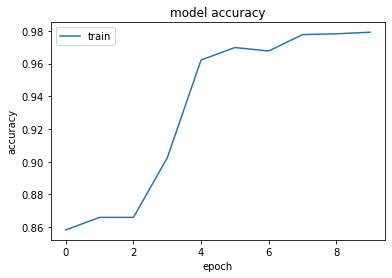

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

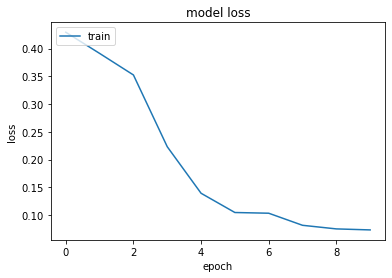

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evalulate

In [13]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 53s 1s/step - loss: 0.0768 - accuracy: 0.9742


[0.07684112340211868, 0.9741564989089966]

# Test

In [14]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.96385276],
       [0.9648154 ],
       [0.92841053],
       [0.01667449],
       [0.00885528]], dtype=float32)